In [34]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Rather than try to ID all lines, instead fit all lines in Linsky paper, and get upper limits for Peacock+ lines.

In [2]:
line_tab = Table.read('linsky_lines.tsv', format ='ascii')
line_tab

Wavelength,Ion,Formation,α Cen A (G2 V),ϵ Eri (K2 V),AU Mic (dM1e),mult,t_uncert
float64,str8,float64,float64,float64,float64,str4,str4
30.392,Heii,4.9,4.7,33.0,340.0,--,TRUE
58.4334,Hei,4.65,--,--,--,--,TRUE
97.702,Ciii,4.72,5.2,13.5,79.6,--,--
102.572,Hi (Lyβ),4.5,--,--,--,--,TRUE
103.193,Ovi,5.43,2.21,14.5,109.0,--,--
103.634,Cii,4.3,0.188,0.502,3.64,--,--
103.702,Cii,4.3,0.283,1.04,6.76,--,--
103.762,Ovi,5.43,1.06,7.67,55.1,--,--
117.6,Ciii,4.72,2.48,10.9,66.0,TRUE,--


In [10]:
lines = line_tab['Wavelength']*10
len(lines[lines > 1100])

29

In [15]:
#t1data = Table.read('../combined/trappist-1_sed_var_res_v04.ecsv')
t1data = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')

In [138]:
w, f , e = t1data['WAVELENGTH'], t1data['FLUX'], t1data['ERROR']

In [139]:
cos_cut = (w > 1100) & (w < 3100)
w, f, e = w[cos_cut], f[cos_cut], e[cos_cut]

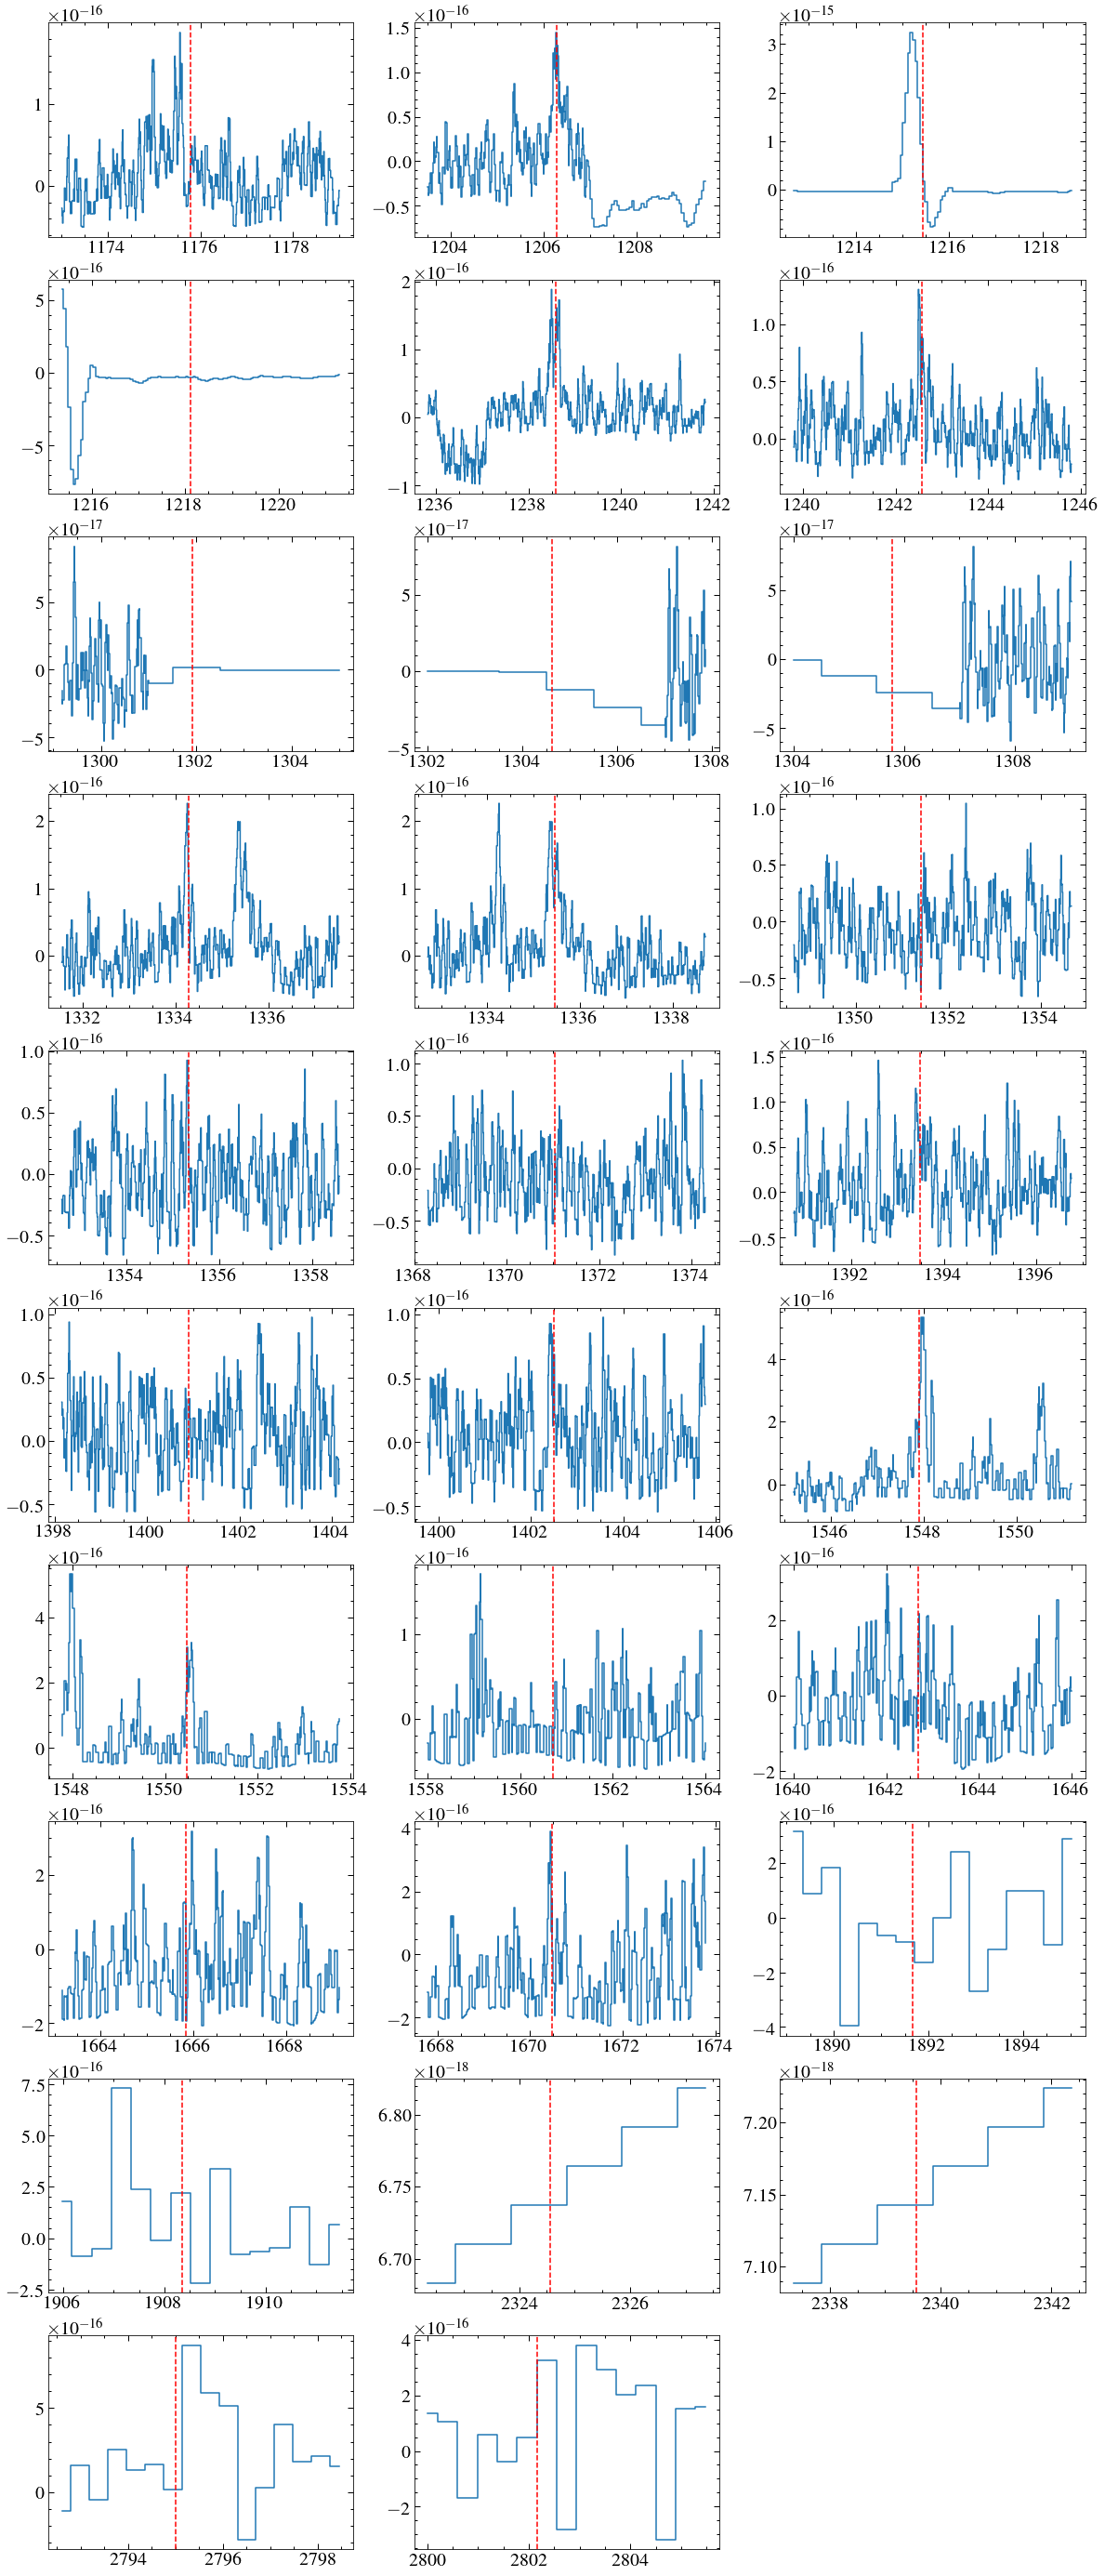

In [20]:
smooth = 5
dv = -56.3*u.km/u.s
plt.figure(figsize=(20, 50))
for i, line in enumerate(lines[lines > 1100]):
    line_mask = (w > line-3) & (w < line+3)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(10, 3, i+1)
    plt.step(w1, f1, where='mid')
    dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    plt.axvline(dv_line.value, c='r', ls='--')
    #plt.show()

In [24]:
line_data = [1176., 1206.51, 1218.344, 1238.821, 1242.804,
       1334.532, 1335.708, 1351.657,
       1355.598, 1371.292, 1393.755, 1401.156, 1402.77 , 1548.195,
       1550.77 , 1561.   , 1643.   , 1666.153, 1670.787, 2795.523, 2802.697] #lines for which data exists

array([1176.   , 1206.51 , 1215.67 , 1218.344, 1238.821, 1242.804,
       1302.169, 1304.858, 1306.029, 1334.532, 1335.708, 1351.657,
       1355.598, 1371.292, 1393.755, 1401.156, 1402.77 , 1548.195,
       1550.77 , 1561.   , 1643.   , 1666.153, 1670.787, 1892.03 ,
       1908.7  , 2325.   , 2340.   , 2795.523, 2802.697])

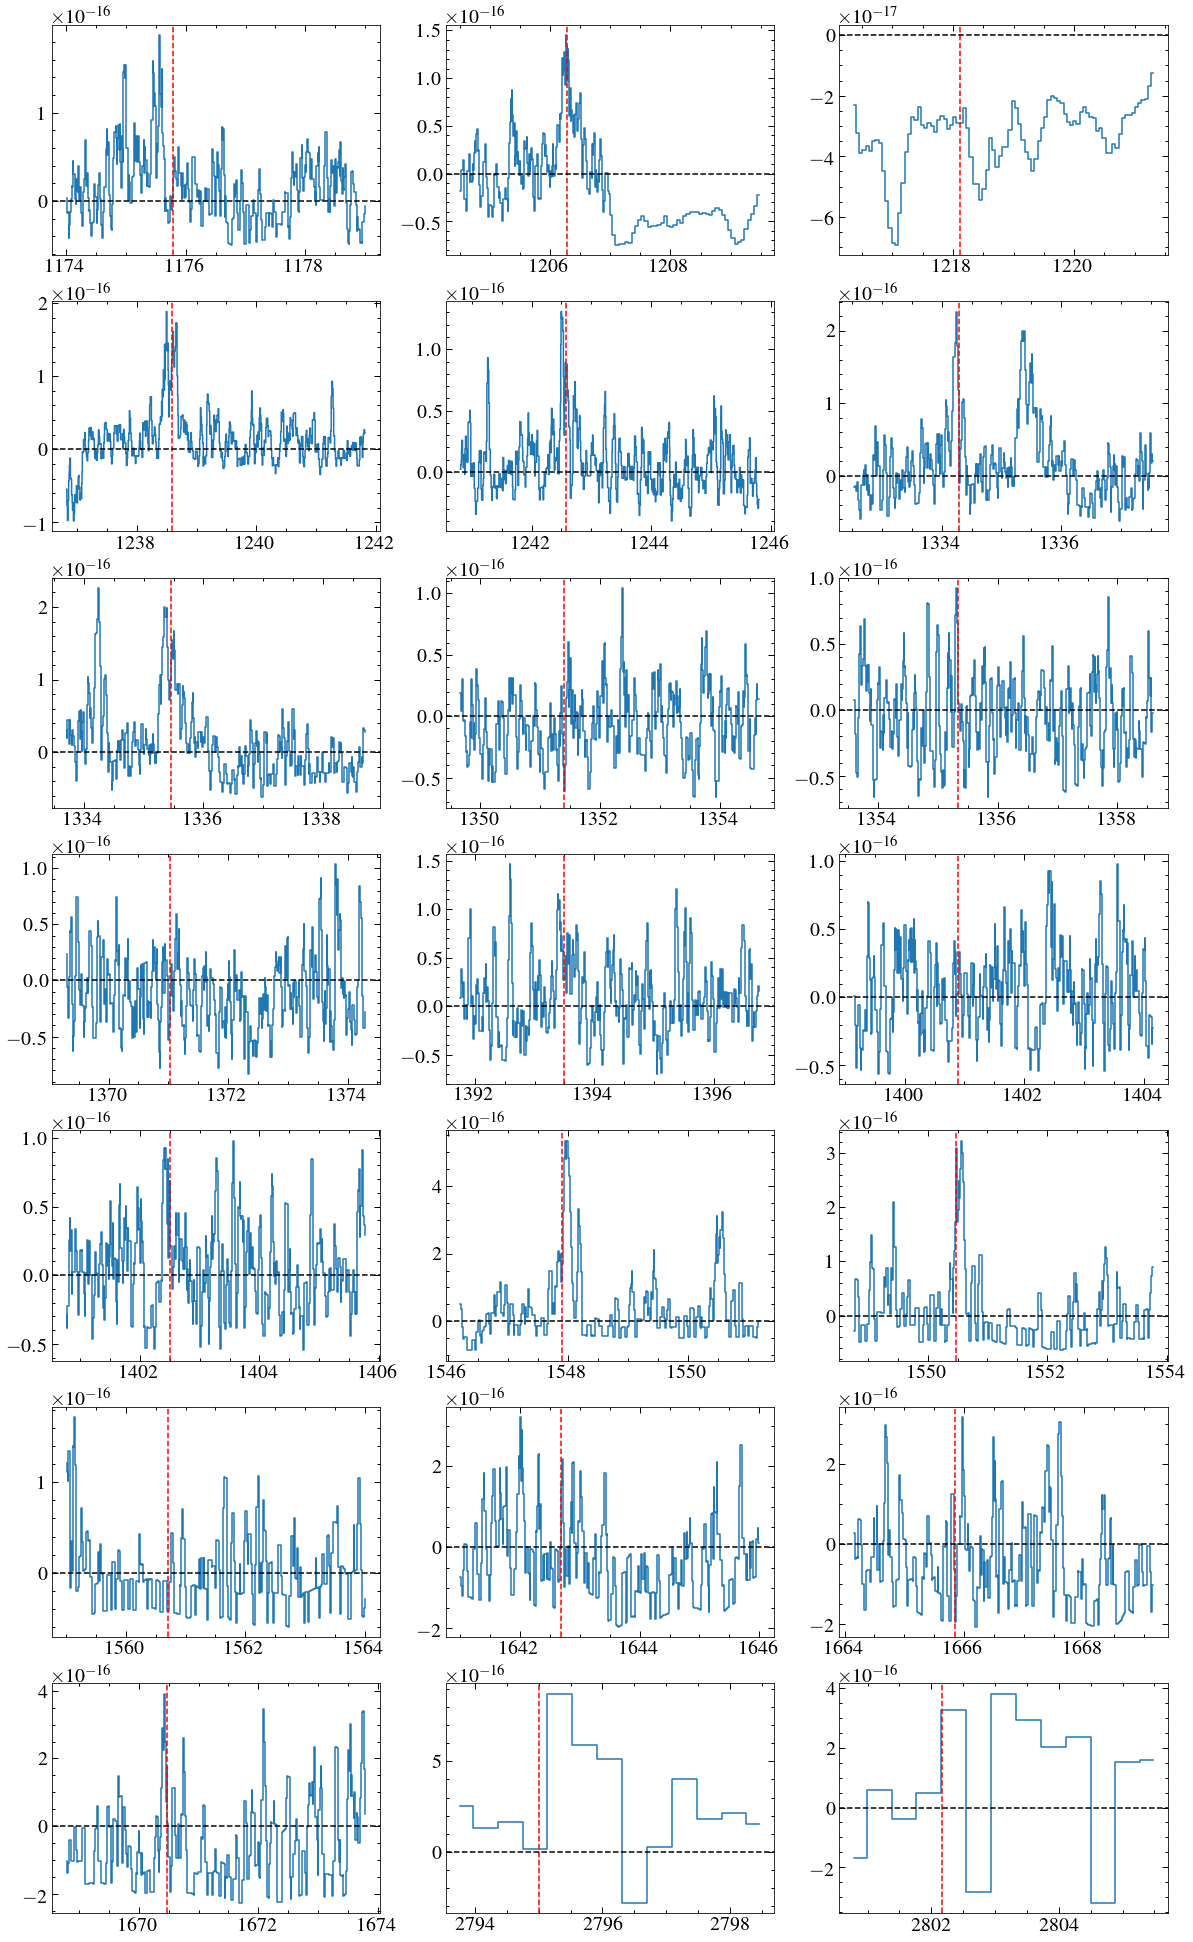

In [28]:
plt.figure(figsize=(20, 50))
for i, line in enumerate(line_data):
    line_mask = (w > line-2) & (w < line+3)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(10, 3, i+1)
    plt.step(w1, f1, where='mid')
    dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    plt.axvline(dv_line.value, c='r', ls='--')
    plt.axhline(0,c='k', ls='--')

In [32]:
detected_lines = [1176., 1206.51, 1238.821, 1242.804,
       1334.532, 1335.708, 1393.755, 1402.77 , 1548.195,
       1550.77, 1670.787, 2795.523] #lines that are  visually detected

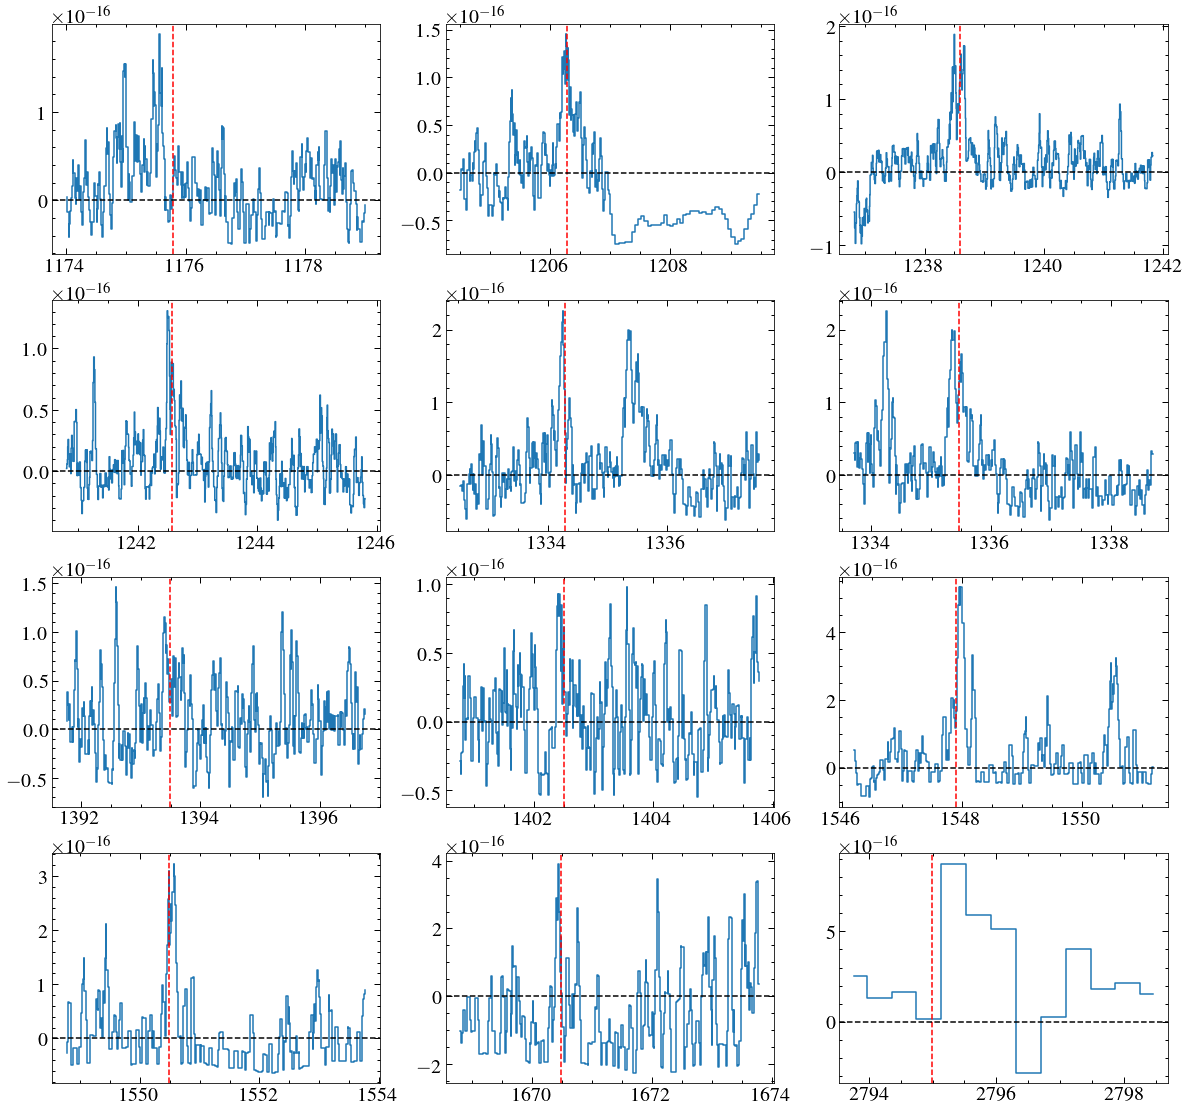

In [33]:
plt.figure(figsize=(20, 50))
for i, line in enumerate(detected_lines):
    line_mask = (w > line-2) & (w < line+3)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(10, 3, i+1)
    plt.step(w1, f1, where='mid')
    dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    plt.axvline(dv_line.value, c='r', ls='--')
    plt.axhline(0,c='k', ls='--')

In [35]:
fitter = fitting.LevMarLSQFitter()


4.2104334478457356e-17 5.294406144765981e-17 -1.8878304189775972e-17 1.2846620970905554e-16 4.2104334478457356e-17
4.383470630781589e-16 4.5182159686045015e-17 3.386300159835626e-16 3.690299984142773e-16 2.2309845129794566e-17
1175.4959999999999 8.16636498055298e-17 3.906010477724866e-16
1206.51 4.546333330529332e-17 8.144952189506584e-18
1238.821 5.290199570313293e-17 1.00821808649451e-17
1334.532 9.16666040696926e-17 3.336724668726945e-17
1393.755 2.1215676904874537e-17 1.8741771103628282e-17
1402.77 1.0586271804924283e-17 7.032604804362475e-18
1548.202 1.488500749672665e-16 9.957608552145026e-17
2795.523 6.280376099121266e-16 3.7566419106310353e-16


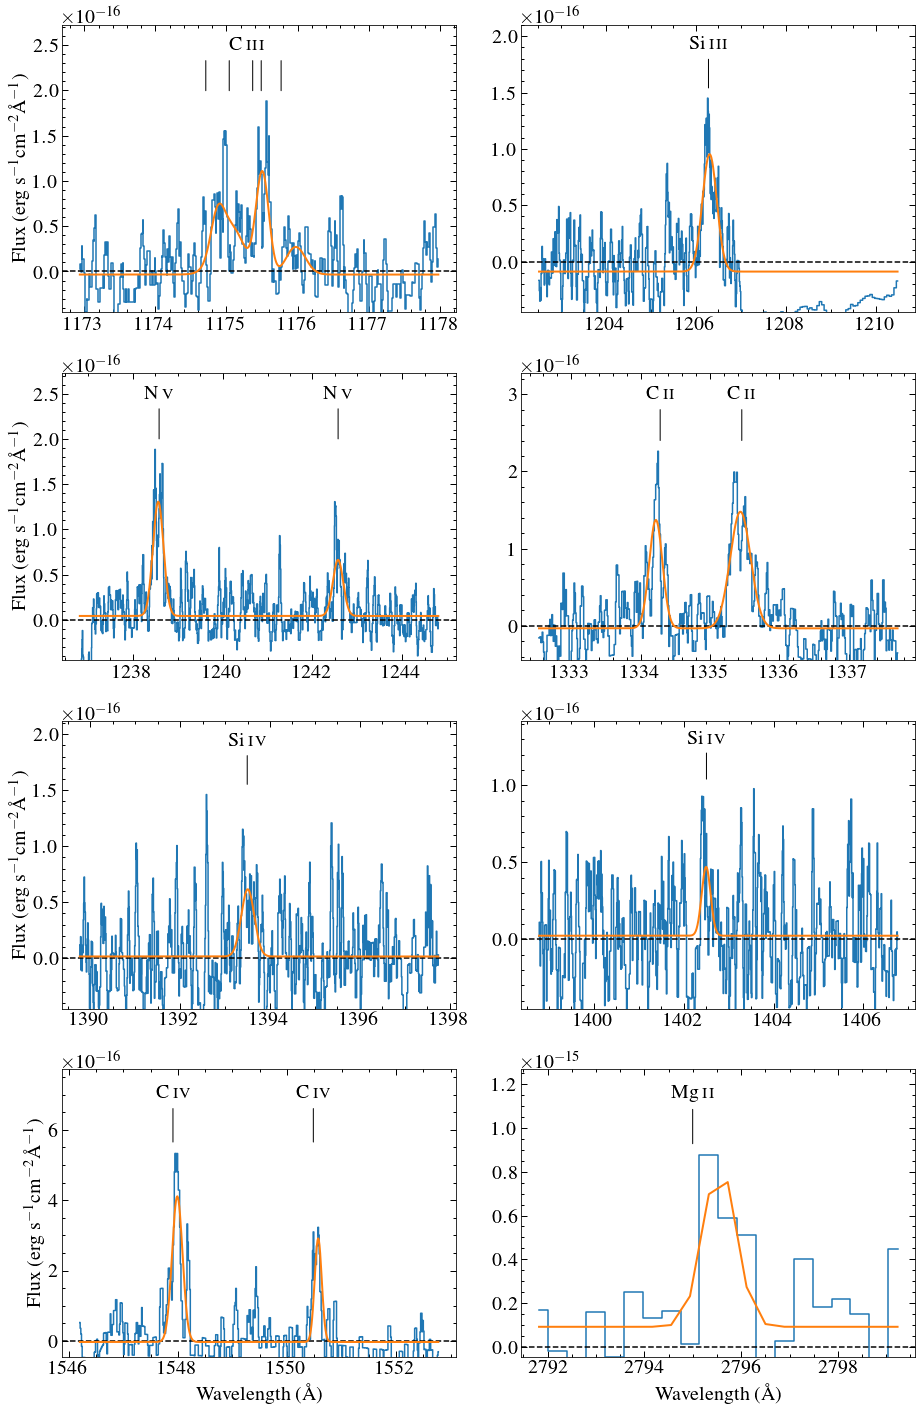

In [132]:
def gauss_flux(amp, std, off, ae, se, oe):
    """
    Calcualates the flux and error of a Gaussian with amplitude and stddev amp and std, with offset off
    """
    off_err = 0
    if off != 0.0:
        amp += (-1*off)
        off_err = (oe/off)**2
        
    flux = ((2*np.pi)**0.5) * amp * std
    error = flux * (((ae/amp)**2)+((se/std)**2)+off_err)**0.5
    return flux, error
               


ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99]
siiii_1206 = [1206.51, 1206.53]
nv_1240 = [1238.821, 1242.804]
ci_1288 = [1288.918]
feii_1292 = [1292.405]
cii_1335 = [1334.532, 1335.708]
feii_1527 = [1527.2397] 
civ_1550 = [1548.202,1550.774]
mgii_2800 = [2795.528]

line_fluxes = []
line_errors = [] 

measured_lines = [ciii_1175, [1206.51], nv_1240, cii_1335, [1393.755], [1402.77], civ_1550, [2795.523]]
plot_name = np.array(['C\,{\sc iii}', 'Si\,{\sc iii}', 'N\,{\sc v}', 'C\,{\sc ii}', 'Si\,{\sc iv}','Si\,{\sc iv}',
                       'C\,{\sc iv}', 'Mg\,{\sc ii}'])  


plt.figure(figsize=(13, 20))


for i, lineset in enumerate(measured_lines):
    line = lineset[0]
    if len(lineset) == 1:
        line_mask = (w > line-4) & (w < line+4)
    #elif i ==0:
     #   line_mask = (w > lineset[0]-4) & (w < lineset[-1]+4)
    else:
        line_mask = (w > lineset[0]-2) & (w < lineset[-1]+2)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(4, 2, i+1)
    plt.step(w1, f1, where='mid')
    #dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)) for line in lineset]
    #[plt.axvline(dv_line.value, c='r', ls='--') for dv_line in dv_lines]
    plt.axhline(0,c='k', ls='--') 
    gg_init = models.Const1D(0.0)
    for li in lineset:
        #if i in [5,7]:
         #   li -=0.2
        li = dv.to(u.AA, equivalencies=u.doppler_optical(li*u.AA))
        gg_init += models.Gaussian1D(1e-16, li,0.1)
    gg_fit = fitter(gg_init, w1, f1, maxiter=10000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    if i ==0:
        print(gg_fit[1].amplitude.value, gg_fit[2].amplitude.value, gg_fit[3].amplitude.value, gg_fit[4].amplitude.value, gg_fit[1].amplitude.value)
        print(fit_e[1], fit_e[4], fit_e[7], fit_e[10], fit_e[13])
    plt.plot(w1,gg_fit(w1), lw=2)
    #minplot = -abs(f1[int(len(f1)/2)])*1.1
    plt.ylim(-0.45e-16, max(f1)*1.45)
    dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
    #[plt.annotate(name,(line*dshift, top*1.05), xytext=(line*dshift, top*1.3), horizontalalignment='center') for name, line in zip(plot_name[nmask], lines[nmask])]
    [plt.annotate('',(dv_line, max(f1)*1.05), xytext=(dv_line, max(f1)*1.25),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for dv_line in dv_lines]
    name = plot_name[i]
    if i == 0:
        line = np.mean(lineset)
        dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
        plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center')
    else:
        dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
        [plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center') for dv_line in dv_lines]
    if i  in (0, 2, 4, 6):
        plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
    if i in (6,7):
        plt.xlabel('Wavelength (\AA)')
    #calculate flux
    off, oe = gg_fit[0].amplitude, fit_e[0]
    if i == 7:
        off, oe = 0,0
        
    flux = []
    error = []
    for i in range(len(lineset)):
        
        amp, ae = gg_fit[i+1].amplitude, fit_e[3*i+1]
        std, se = gg_fit[i+1].stddev, fit_e[3*i+2]
        if amp > 0 and std >0: 
            f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
            flux.append(f_l)
            error.append(e_l)
    flux = np.sum(np.array(flux))
    error = np.sum(np.array(error)**2)**0.5
    line_fluxes.append(flux)
    line_errors.append(error)
    print(line, flux, error)
        
        

        
plt.tight_layout()
#plt.savefig('t1_detected_lines.pdf', dpi=150)
                   

    
    


In [127]:
table_lines = [ciii_1175, [1206.51], nv_1240, cii_1335, [1393.755], [1402.77], civ_1550, [2795.523]]

1174.93 8.16636498055298e-17 3.906010477724866e-16
1206.51 4.546333330529332e-17 8.144952189506584e-18
1238.821 3.7993972946982463e-17 1.9928240677739552e-17
1242.804 1.7257249974226103e-17 4.721447120138718e-18
1334.532 3.1780682671814505e-17 7.255044247166342e-17
1335.708 5.460559526035456e-17 5.4781864611830203e-17
1393.755 2.1215676904874537e-17 1.8741771103628282e-17
1402.77 1.0586271804924283e-17 7.032604804362475e-18
1548.202 9.625770473844453e-17 2.0305760961947342e-16
1550.774 3.688845560409329e-17 1.915804925232896e-17
2795.523 5.516628071172511e-16 3.537125159714818e-16


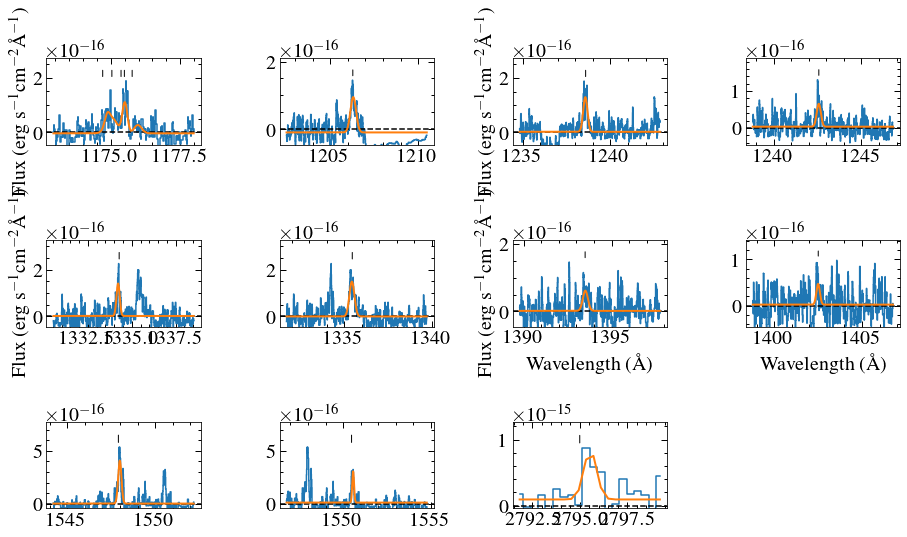

In [146]:
ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99]
siiii_1206 = [1206.51, 1206.53]
nv_1240 = [1238.821, 1242.804]
ci_1288 = [1288.918]
feii_1292 = [1292.405]
cii_1335 = [1334.532, 1335.708]
feii_1527 = [1527.2397] 
civ_1550 = [1548.202,1550.774]
mgii_2800 = [2795.528]

line_fluxes = []
line_errors = [] 

measured_lines2 = [ciii_1175, [1206.51],[1238.821], [1242.804] ,[1334.532], [1335.708], [1393.755], [1402.77], [1548.202],[1550.774], [2795.523]]
#plot_name = np.array(['C\,{\sc iii}', 'Si\,{\sc iii}', 'N\,{\sc v}', 'C\,{\sc ii}', 'Si\,{\sc iv}','Si\,{\sc iv}',
                   #    'C\,{\sc iv}', 'Mg\,{\sc ii}'])  


plt.figure(figsize=(13, 20))


for i, lineset in enumerate(measured_lines2):
    line = lineset[0]
    if len(lineset) == 1:
        line_mask = (w > line-4) & (w < line+4)
    #elif i ==0:
     #   line_mask = (w > lineset[0]-4) & (w < lineset[-1]+4)
    else:
        line_mask = (w > lineset[0]-2) & (w < lineset[-1]+2)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(8, 4, i+1)
    plt.step(w1, f1, where='mid')
    #dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)) for line in lineset]
    #[plt.axvline(dv_line.value, c='r', ls='--') for dv_line in dv_lines]
    plt.axhline(0,c='k', ls='--') 
    gg_init = models.Const1D(0.0)
    for li in lineset:
        #if i in [5,7]:
         #   li -=0.2
        li = dv.to(u.AA, equivalencies=u.doppler_optical(li*u.AA))
        gg_init += models.Gaussian1D(1e-16, li,0.1)
    gg_fit = fitter(gg_init, w1, f1, maxiter=10000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
  #  if i ==0:
   #     print(gg_fit[1].amplitude.value, gg_fit[2].amplitude.value, gg_fit[3].amplitude.value, gg_fit[4].amplitude.value, gg_fit[1].amplitude.value)
    #    print(fit_e[1], fit_e[4], fit_e[7], fit_e[10], fit_e[13])
    plt.plot(w1,gg_fit(w1), lw=2)
    #minplot = -abs(f1[int(len(f1)/2)])*1.1
    plt.ylim(-0.45e-16, max(f1)*1.45)
    dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
    #[plt.annotate(name,(line*dshift, top*1.05), xytext=(line*dshift, top*1.3), horizontalalignment='center') for name, line in zip(plot_name[nmask], lines[nmask])]
    [plt.annotate('',(dv_line, max(f1)*1.05), xytext=(dv_line, max(f1)*1.25),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for dv_line in dv_lines]
    #name = plot_name[i]
 #   if i == 0:
  #      line = np.mean(lineset)
   #     dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    #    plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center')
  #  else:
   #     dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
    #    [plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center') for dv_line in dv_lines]
    if i  in (0, 2, 4, 6):
        plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
    if i in (6,7):
        plt.xlabel('Wavelength (\AA)')
    #calculate flux
    off, oe = gg_fit[0].amplitude, fit_e[0]
    if i == 10:
        oe = 0.1*off
        
    flux = []
    error = []
    for i in range(len(lineset)):
        
        amp, ae = gg_fit[i+1].amplitude, fit_e[3*i+1]
        std, se = gg_fit[i+1].stddev, fit_e[3*i+2]
        if amp > 0: 
            f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
            flux.append(f_l)
            error.append(e_l)
    flux = np.sum(np.array(flux))
    error = np.sum(np.array(error)**2)**0.5
    line_fluxes.append(flux)
    line_errors.append(error)
    print(line, flux, error)
        
        

        
plt.tight_layout()

In [156]:
def Round_n_sig_dig(x, n):

    import numpy as np               
    xr = (np.floor(np.log10(np.abs(x)))).astype(int)
    xr=10.**xr*np.around(x/10.**xr,n-1)   
    return xr

table_lines = [1176, 1206.51,1238.821, 1242.804 ,1334.532, 1335.708, 1393.755, 1402.77, 1548.202,1550.774, 2795.523]
table_fluxes, table_errors = np.array(line_fluxes)*1e18,np.array(line_errors)*1e18
table_fluxes, table_errors = Round_n_sig_dig(table_fluxes,2), Round_n_sig_dig(table_errors, 2)

for tl, tf, te in zip(table_lines, table_fluxes, table_errors):
    print(tl,tf,te)

1176 82.0 390.0
1206.51 45.0 8.1
1238.821 38.0 20.0
1242.804 17.0 4.7
1334.532 32.0 73.0
1335.708 55.0 55.0
1393.755 21.0 19.0
1402.77 11.0 7.0
1548.202 96.0 200.0
1550.774 37.0 19.0
2795.523 550.0 350.0


Need to measure the C line differently